In [1]:
import numpy as np
from functools import reduce
from collections import namedtuple
from typing import List, Tuple, Union

MAXSIDE = 100
MAXAREA = 40 * 40
MAXPIXELS = 40 * 40 * 5

import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'src', 'arclang')))
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from image import Image, Point
from function import *

In [19]:
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Callable
from collections import namedtuple
from matplotlib.colors import ListedColormap, BoundaryNorm

Point = namedtuple("Point", ["x", "y"])

def display_matrix(matrix):
    colors = [
        "#000000",  # black
        "#0074D9",  # blue
        "#FF4136",  # red
        "#2ECC40",  # green
        "#FFDC00",  # yellow
        "#AAAAAA",  # grey
        "#F012BE",  # fuchsia
        "#FF851B",  # orange
        "#7FDBFF",  # teal
        "#870C25",  # brown
    ]
    cmap = ListedColormap(colors)
    bounds = np.arange(-0.5, 10, 1)
    norm = BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    cax = ax.matshow(matrix.mask, cmap=cmap, norm=norm)
    ax.set_title("Matrix")

    fig.colorbar(
        cax, ax=ax, ticks=np.arange(0, 10), orientation="vertical"
    ).ax.set_yticklabels(
        [
            "Symbol 0",
            "Symbol 1",
            "Symbol 2",
            "Symbol 3",
            "Symbol 4",
            "Symbol 5",
            "Symbol 6",
            "Symbol 7",
            "Symbol 8",
            "Symbol 9",
        ]
    )

    plt.show()

class SQLParser:
    def __init__(self):
        self.commands = []

    def parse(self, sql_string: str) -> List[Tuple[str, List[str]]]:
        raw_commands = sql_string.split(';')
        for cmd in raw_commands:
            cmd = cmd.strip()
            if cmd:
                parts = cmd.split()
                operation = parts[0].upper()
                args = parts[1:]
                self.commands.append((operation, args))
        return self.commands

class CommandMapper:
    def __init__(self):
        self.function_map = {
            'SELECT': self.select,
            'FILL': self.fill,
            'REPLACE': self.replace,
            'EXPAND': self.expand,
            'SHRINK': self.shrink,
            'CLEAR': self.clear,
            'COPY': self.copy,
            'MOVE': self.move,
            'ROTATE': self.rotate,
            'FLIP': self.flip,
            'OVERLAY': self.overlay,
            'SUBTRACT': self.subtract,
            'INTERSECT': self.intersect,
            'APPLY_PATTERN': self.apply_pattern,
            'COUNT': self.count,
            'DISPLAY': self.display,
        }

    def select(self, args: List[str]) -> Callable[[Image], Image]:
        x1, y1, x2, y2 = map(int, args)
        return lambda img: self.create_selection_mask(img, x1, y1, x2, y2)

    def create_selection_mask(self, img: Image, x1: int, y1: int, x2: int, y2: int) -> Image:
        mask = np.zeros((img.h, img.w), dtype=bool)
        mask[y1:y2, x1:x2] = True
        img.selection_mask = mask
        return img

    def apply_to_selection(self, func: Callable[[Image], Image]) -> Callable[[Image], Image]:
        return lambda img: self.apply_func_to_selection(img, func)

    def apply_func_to_selection(self, img: Image, func: Callable[[Image], Image]) -> Image:
        if hasattr(img, 'selection_mask'):
            selected_area = img.sub_image(Point(0, 0), Point(img.w, img.h))
            selected_area.mask = np.where(img.selection_mask, img.mask, 0)
            modified_area = func(selected_area)
            result = img.copy()
            result.mask = np.where(img.selection_mask, modified_area.mask, img.mask)
            return result
        else:
            return func(img)


    def fill(self, args: List[str]) -> Callable[[Image], Image]:
        color = int(args[0])
        return self.apply_to_selection(lambda img: Image.full(Point(img.x, img.y), Point(img.w, img.h), color))

    def replace(self, args: List[str]) -> Callable[[Image], Image]:
        old_color, new_color = map(int, args[:2])
        return self.apply_to_selection(lambda img: compose(img, col(new_color), lambda x, y: new_color if x == old_color else x, 0))
    def replace_in_area(self, img: Image, old_color: int, new_color: int, x1: int, y1: int, x2: int, y2: int) -> Image:
        result = img.copy()
        for y in range(y1, y2):
            for x in range(x1, x2):
                if result[y, x] == old_color:
                    result[y, x] = new_color
        return result

    def expand(self, args: List[str]) -> Callable[[Image], Image]:
        size, mode = int(args[0]), args[1].upper()
        return lambda img: extend2(img, Image.full(Point(img.x-size, img.y-size), Point(img.w+2*size, img.h+2*size), 0))

    def shrink(self, args: List[str]) -> Callable[[Image], Image]:
        size = int(args[0])
        return lambda img: img.sub_image(Point(size, size), Point(img.w-2*size, img.h-2*size))

    def clear(self, args: List[str]) -> Callable[[Image], Image]:
        return lambda img: Image.empty(img.x, img.y, img.w, img.h)

    def copy(self, args: List[str]) -> Callable[[Image], Image]:
        x, y = map(int, args)
        return lambda img: compose_id(img, move(img, pos(x, y)), 0)

    def move(self, args: List[str]) -> Callable[[Image], Image]:
        x, y = map(int, args)
        return lambda img: move(img, pos(x, y))

    def rotate(self, args: List[str]) -> Callable[[Image], Image]:
        angle = int(args[0])
        return lambda img: rigid(img, angle // 90)

    def flip(self, args: List[str]) -> Callable[[Image], Image]:
        axis = args[0].upper()
        return lambda img: rigid(img, 4 if axis == 'HORIZONTAL' else 5)

    def overlay(self, args: List[str]) -> Callable[[Image], Image]:
        return lambda img: compose_id(img, img, 3)

    def subtract(self, args: List[str]) -> Callable[[Image], Image]:
        return lambda img: compose_id(img, invert(img), 2)

    def intersect(self, args: List[str]) -> Callable[[Image], Image]:
        return lambda img: compose_id(img, img, 2)

    def apply_pattern(self, args: List[str]) -> Callable[[Image], Image]:
        pattern_type = args[0].upper()
        if pattern_type == 'CHECKERBOARD':
            return lambda img: compose(img, Image.full(Point(0, 0), Point(img.w, img.h), 1), lambda x, y: y if (x + y) % 2 else x, 0)
        elif pattern_type == 'STRIPES':
            return lambda img: compose(img, Image.full(Point(0, 0), Point(img.w, img.h), 1), lambda x, y: y if x % 2 else x, 0)
        else:
            return lambda img: img  # Default to no change for unsupported patterns

    def count(self, args: List[str]) -> Callable[[Image], int]:
        color = int(args[0])
        return lambda img: np.sum(img.mask == color)

    def display(self, args: List[str]) -> Callable[[Image], None]:
        return lambda img: display_matrix(img)

class SQLExecutionEngine:
    def __init__(self, image: Image):
        self.image = image
        self.parser = SQLParser()
        self.mapper = CommandMapper()

    def execute(self, sql_string: str) -> Image:
        commands = self.parser.parse(sql_string)
        for operation, args in commands:
            if operation in self.mapper.function_map:
                func = self.mapper.function_map[operation](args)
                if operation == 'COUNT':
                    print(f"Count result: {func(self.image)}")
                elif operation == 'DISPLAY':
                    func(self.image)
                else:
                    self.image = func(self.image)
            else:
                print(f"Unknown operation: {operation}")
        return self.image

# Usage example



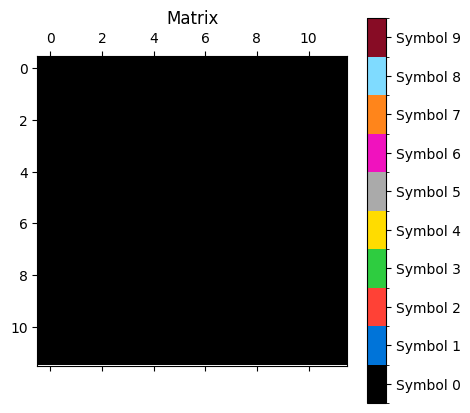

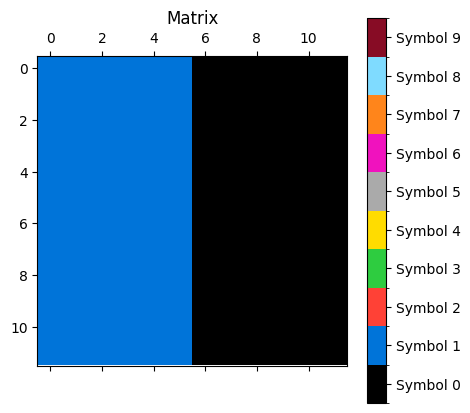

In [24]:
initial_image = Image(0, 0, 12, 12)
engine = SQLExecutionEngine(initial_image)
sql_commands = """
SELECT 0 0 6 12;
FILL 1;
DISPLAY;
"""
display_matrix(initial_image)

result_image = engine.execute(sql_commands)

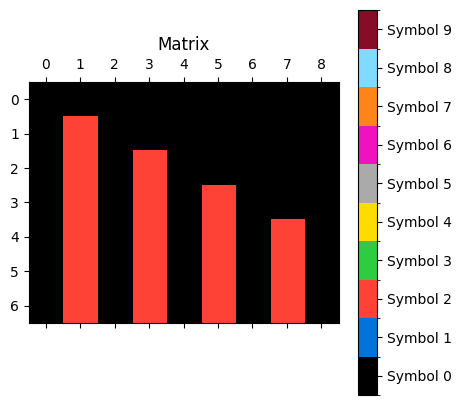

In [25]:
path = "/home/sai/Desktop/arc/ARC-AGI/data/training/ce9e57f2.json"
with open(path,"r") as f:
    data_ce9 = json.loads(f.read())
img_mask = data_ce9["train"][0]["input"]
img_mask = np.array(img_mask)
img_mask.shape
input_img= Image(0,0,9,7,img_mask)
display_matrix(input_img)

In [36]:

engine = SQLExecutionEngine(input_img)

sql_commands = """
SELECT 0 0 7 7;
FOREACH 2 (
  SELECT [COL] 0 [COL+1] 7;
  REPLACE 2 1 IN [COL] 3 [COL+1] 7;
);
DISPLAY;"""

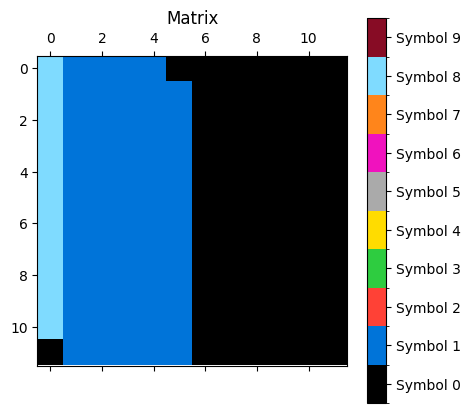

In [40]:
import numpy as np
from typing import List, Tuple, Callable
from collections import namedtuple

Point = namedtuple("Point", ["x", "y"])

class SQLParser:
    def __init__(self):
        self.commands = []

    def parse(self, sql_string: str) -> List[Tuple[str, List[str]]]:
        raw_commands = sql_string.split(';')
        for cmd in raw_commands:
            cmd = cmd.strip()
            if cmd:
                parts = cmd.split()
                operation = parts[0].upper()
                args = parts[1:]
                self.commands.append((operation, args))
        return self.commands

class CommandMapper:
    def __init__(self):
        self.function_map = {
            'SELECT': self.select,
            'FILL': self.fill,
            'EXPAND': self.expand,
            'SHRINK': self.shrink,
            'CLEAR': self.clear,
            'COPY': self.copy,
            'MOVE': self.move,
            'ROTATE': self.rotate,
            'FLIP': self.flip,
            'REPLACE': self.replace,
            'OVERLAY': self.overlay,
            'SUBTRACT': self.subtract,
            'INTERSECT': self.intersect,
            'REPEAT': self.repeat,
            'APPLY_PATTERN': self.apply_pattern,
            'COUNT': self.count,
            'GROUP': self.group,
            'FOREACH': self.foreach,
            'IF': self.if_condition,
            'WHILE': self.while_loop,
            'CONVOLVE': self.convolve,
            'APPLY_FILTER': self.apply_filter,
            'SCALE': self.scale,
            'SHIFT': self.shift,
            'EXTRUDE': self.extrude,
            'ERODE': self.erode,
            'DILATE': self.dilate,
            'RANDOMIZE': self.randomize,
            'SORT_COLORS': self.sort_colors,
            'BLUR': self.blur,
            'SHARPEN': self.sharpen,
            'INVERT_COLORS': self.invert_colors,
            'ADJUST_BRIGHTNESS': self.adjust_brightness,
            'ADJUST_CONTRAST': self.adjust_contrast,
            'APPLY_GRADIENT': self.apply_gradient,
            'CREATE_BORDER': self.create_border,
            'CROP': self.crop,
            'RESIZE': self.resize,
            'APPLY_MASK': self.apply_mask,
            'BLEND': self.blend,
            'RECURSIVE': self.recursive,
            'DISPLAY': self.display,
        }
        self.selected_area = None

    def select(self, args: List[str]) -> Callable[[Image], Image]:
        x1, y1, x2, y2 = map(int, args)
        self.selected_area = (x1, y1, x2, y2)
        return lambda img: img

    def fill(self, args: List[str]) -> Callable[[Image], Image]:
        color = int(args[0])
        return lambda img: self.apply_to_selected_area(img, lambda area: Image.full(Point(area.x, area.y), Point(area.w, area.h), color))

    def expand(self, args: List[str]) -> Callable[[Image], Image]:
        size = int(args[0])
        return lambda img: self.apply_to_selected_area(img, lambda area: extend2(area, Image.full(Point(area.x-size, area.y-size), Point(area.w+2*size, area.h+2*size), 0)))

    def shrink(self, args: List[str]) -> Callable[[Image], Image]:
        size = int(args[0])
        return lambda img: self.apply_to_selected_area(img, lambda area: area.sub_image(Point(size, size), Point(area.w-2*size, area.h-2*size)))

    def clear(self, args: List[str]) -> Callable[[Image], Image]:
        return lambda img: self.apply_to_selected_area(img, lambda area: Image.empty(area.x, area.y, area.w, area.h))

    def copy(self, args: List[str]) -> Callable[[Image], Image]:
        x, y = map(int, args)
        return lambda img: self.apply_to_selected_area(img, lambda area: compose_id(area, move(area, pos(x, y)), 0))

    def move(self, args: List[str]) -> Callable[[Image], Image]:
        x, y = map(int, args)
        return lambda img: self.apply_to_selected_area(img, lambda area: move(area, pos(x, y)))

    def rotate(self, args: List[str]) -> Callable[[Image], Image]:
        angle = int(args[0])
        return lambda img: self.apply_to_selected_area(img, lambda area: rigid(area, angle // 90))

    def flip(self, args: List[str]) -> Callable[[Image], Image]:
        axis = args[0].upper()
        return lambda img: self.apply_to_selected_area(img, lambda area: rigid(area, 4 if axis == 'HORIZONTAL' else 5))

    def replace(self, args: List[str]) -> Callable[[Image], Image]:
        old_color, new_color = map(int, args[:2])
        return lambda img: self.apply_to_selected_area(img, lambda area: compose(area, col(new_color), lambda x, y: new_color if x == old_color else x, 0))

    def overlay(self, args: List[str]) -> Callable[[Image], Image]:
        return lambda img: self.apply_to_selected_area(img, lambda area: compose_id(area, area, 3))

    def subtract(self, args: List[str]) -> Callable[[Image], Image]:
        return lambda img: self.apply_to_selected_area(img, lambda area: compose_id(area, invert(area), 2))

    def intersect(self, args: List[str]) -> Callable[[Image], Image]:
        return lambda img: self.apply_to_selected_area(img, lambda area: compose_id(area, area, 2))

    def repeat(self, args: List[str]) -> Callable[[Image], Image]:
        operation, times = args[0], int(args[1])
        return lambda img: self.apply_n_times(img, operation, times)

    def apply_pattern(self, args: List[str]) -> Callable[[Image], Image]:
        pattern_type = args[0].upper()
        if pattern_type == 'CHECKERBOARD':
            return lambda img: self.apply_to_selected_area(img, lambda area: compose(area, Image.full(Point(0, 0), Point(area.w, area.h), 1), lambda x, y: y if (x + y) % 2 else x, 0))
        elif pattern_type == 'STRIPES':
            return lambda img: self.apply_to_selected_area(img, lambda area: compose(area, Image.full(Point(0, 0), Point(area.w, area.h), 1), lambda x, y: y if x % 2 else x, 0))
        # Add more patterns as needed

    def count(self, args: List[str]) -> Callable[[Image], int]:
        color = int(args[0])
        return lambda img: np.sum(img.mask == color)

    def group(self, args: List[str]) -> Callable[[Image], Image]:
        operations = args
        return lambda img: self.apply_operations(img, operations)

    def foreach(self, args: List[str]) -> Callable[[Image], Image]:
        color, operation = args[0], args[1]
        return lambda img: self.apply_to_color(img, color, operation)

    def if_condition(self, args: List[str]) -> Callable[[Image], Image]:
        condition, true_op, false_op = args[0], args[1], args[2]
        return lambda img: self.apply_conditional(img, condition, true_op, false_op)

    def while_loop(self, args: List[str]) -> Callable[[Image], Image]:
        condition, operation = args[0], args[1]
        return lambda img: self.apply_while(img, condition, operation)

    def convolve(self, args: List[str]) -> Callable[[Image], Image]:
        kernel_name, mode = args[0], args[1]
        return lambda img: self.apply_convolution(img, kernel_name, mode)

    def apply_filter(self, args: List[str]) -> Callable[[Image], Image]:
        filter_type, kernel_size = args[0], int(args[1])
        return lambda img: self.apply_image_filter(img, filter_type, kernel_size)

    def scale(self, args: List[str]) -> Callable[[Image], Image]:
        factor = float(args[0])
        return lambda img: self.apply_to_selected_area(img, lambda area: self.scale_image(area, factor))

    def shift(self, args: List[str]) -> Callable[[Image], Image]:
        direction, amount = args[0], int(args[1])
        return lambda img: self.apply_to_selected_area(img, lambda area: self.shift_image(area, direction, amount))

    def extrude(self, args: List[str]) -> Callable[[Image], Image]:
        direction, amount = args[0], int(args[1])
        return lambda img: self.apply_to_selected_area(img, lambda area: self.extrude_image(area, direction, amount))

    def erode(self, args: List[str]) -> Callable[[Image], Image]:
        amount = int(args[0])
        return lambda img: self.apply_to_selected_area(img, lambda area: self.erode_image(area, amount))

    def dilate(self, args: List[str]) -> Callable[[Image], Image]:
        amount = int(args[0])
        return lambda img: self.apply_to_selected_area(img, lambda area: self.dilate_image(area, amount))

    def randomize(self, args: List[str]) -> Callable[[Image], Image]:
        colors = list(map(int, args))
        return lambda img: self.apply_to_selected_area(img, lambda area: self.randomize_colors(area, colors))

    def sort_colors(self, args: List[str]) -> Callable[[Image], Image]:
        direction, criteria = args[0], args[1]
        return lambda img: self.apply_to_selected_area(img, lambda area: self.sort_image_colors(area, direction, criteria))

    def blur(self, args: List[str]) -> Callable[[Image], Image]:
        radius = int(args[0])
        return lambda img: self.apply_to_selected_area(img, lambda area: self.blur_image(area, radius))

    def sharpen(self, args: List[str]) -> Callable[[Image], Image]:
        amount = float(args[0])
        return lambda img: self.apply_to_selected_area(img, lambda area: self.sharpen_image(area, amount))

    def invert_colors(self, args: List[str]) -> Callable[[Image], Image]:
        return lambda img: self.apply_to_selected_area(img, lambda area: invert(area))

    def adjust_brightness(self, args: List[str]) -> Callable[[Image], Image]:
        amount = float(args[0])
        return lambda img: self.apply_to_selected_area(img, lambda area: self.adjust_image_brightness(area, amount))

    def adjust_contrast(self, args: List[str]) -> Callable[[Image], Image]:
        amount = float(args[0])
        return lambda img: self.apply_to_selected_area(img, lambda area: self.adjust_image_contrast(area, amount))

    def apply_gradient(self, args: List[str]) -> Callable[[Image], Image]:
        start_color, end_color, direction = int(args[0]), int(args[1]), args[2]
        return lambda img: self.apply_to_selected_area(img, lambda area: self.create_gradient(area, start_color, end_color, direction))

    def create_border(self, args: List[str]) -> Callable[[Image], Image]:
        width, color = int(args[0]), int(args[1])
        return lambda img: self.apply_to_selected_area(img, lambda area: self.add_border(area, width, color))

    def crop(self, args: List[str]) -> Callable[[Image], Image]:
        x1, y1, x2, y2 = map(int, args)
        return lambda img: img.sub_image(Point(x1, y1), Point(x2-x1, y2-y1))

    def resize(self, args: List[str]) -> Callable[[Image], Image]:
        new_width, new_height, method = int(args[0]), int(args[1]), args[2]
        return lambda img: self.apply_to_selected_area(img, lambda area: self.resize_image(area, new_width, new_height, method))

    def apply_mask(self, args: List[str]) -> Callable[[Image], Image]:
        mask_name, operation = args[0], args[1]
        return lambda img: self.apply_mask_operation(img, mask_name, operation)

    def blend(self, args: List[str]) -> Callable[[Image], Image]:
        layer2_name, mode = args[0], args[1]
        return lambda img: self.blend_images(img, layer2_name, mode)

    def recursive(self, args: List[str]) -> Callable[[Image], Image]:
        operation, depth, condition = args[0], int(args[1]), args[2]
        return lambda img: self.apply_recursive(img, operation, depth, condition)

    def display(self, args: List[str]) -> Callable[[Image], None]:
        return lambda img: display_matrix(img)

    # Helper methods for applying operations
    def apply_to_selected_area(self, img: Image, func: Callable[[Image], Image]) -> Image:
        if self.selected_area:
            x1, y1, x2, y2 = self.selected_area
            selected = img.sub_image(Point(x1, y1), Point(x2-x1, y2-y1))
            modified = func(selected)
            result = img.copy()
            result.mask[y1:y2, x1:x2] = modified.mask
            return result
        return func(img)

    def apply_n_times(self, img: Image, operation: str, n: int) -> Image:
        result = img
        for _ in range(n):
            result = self.function_map[operation]([])(result)
        return result

    def apply_operations(self, img: Image, operations: List[str]) -> Image:
        result = img
        for op in operations:
            result = self.function_map[op]([])(result)
        return result

    def apply_to_color(self, img: Image, color: str, operation: str) -> Image:
        result = img.copy()
        mask = img.mask == int(color)
        selected = img.copy()
        selected.mask = np.where(mask, img.mask, 0)
        modified = self.function_map[operation]([])(selected)
        result.mask = np.where(mask, modified.mask, result.mask)
        return result

    def apply_conditional(self, img: Image, condition: str, true_op: str, false_op: str) -> Image:
        if self.evaluate_condition(img, condition):
            return self.function_map[true_op]([])(img)
        else:
            return self.function_map[false_op]([])(img)

    def apply_while(self, img: Image, condition: str, operation: str) -> Image:
        result = img
        while self.evaluate_condition(result, condition):
            result = self.function_map[operation]([])(result)
        return result

    def apply_convolution(self, img: Image, kernel_name: str, mode: str) -> Image:
        kernel = self.get_kernel(kernel_name)
        return convolve(img, kernel, mode)

    def apply_image_filter(self, img: Image, filter_type: str, kernel_size: int) -> Image:
        kernel = self.get_filter_kernel(filter_type, kernel_size)
        return convolve(img, kernel, 'SAME')

    def scale_image(self, img: Image, factor: float) -> Image:
        new_w, new_h = int(img.w * factor), int(img.h * factor)
        return resize(img, new_w, new_h, 'NEAREST')

    def shift_image(self, img: Image, direction: str, amount: int) -> Image:
        dx = amount if direction == 'RIGHT' else -amount if direction == 'LEFT' else 0
        dy = amount if direction == 'DOWN' else -amount if direction == 'UP' else 0
        return move(img, pos(dx, dy))

    def extrude_image(self, img: Image, direction: str, amount: int) -> Image:
        # Implementation depends on how you want to handle extrusion
        pass

    def erode_image(self, img: Image, amount: int) -> Image:
        return erode(img, amount)

    def dilate_image(self, img: Image, amount: int) -> Image:
        return dilate(img, amount)

    def randomize_colors(self, img: Image, colors: List[int]) -> Image:
        return randomize(img, colors)

    def sort_image_colors(self, img: Image, direction: str, criteria: str) -> Image:
        # Implementation depends on how you want to handle color sorting
        pass

    def blur_image(self, img: Image, radius: int) -> Image:
        return blur(img, radius)

    def sharpen_image(self, img: Image, amount: float) -> Image:
        return sharpen(img, amount)

    def adjust_image_brightness(self, img: Image, amount: float) -> Image:
        # Implementation depends on how you want to handle brightness adjustment
        pass

    def adjust_image_contrast(self, img: Image, amount: float) -> Image:
        # Implementation depends on how you want to handle contrast adjustment
        pass

    def create_gradient(self, img: Image, start_color: int, end_color: int, direction: str) -> Image:
        return apply_gradient(img, start_color, end_color, direction)

    def add_border(self, img: Image, width: int, color: int) -> Image:
        return create_border(img, width, color)

    def resize_image(self, img: Image, new_width: int, new_height: int, method: str) -> Image:
        return resize(img, new_width, new_height, method)

    def apply_mask_operation(self, img: Image, mask_name: str, operation: str) -> Image:
        mask = self.get_mask(mask_name)
        return apply_mask(img, mask, self.function_map[operation]([]))

    def blend_images(self, img1: Image, img2_name: str, mode: str) -> Image:
        img2 = self.get_image(img2_name)
        return blend(img1, img2, mode)

    def apply_recursive(self, img: Image, operation: str, depth: int, condition: str) -> Image:
        if depth == 0 or not self.evaluate_condition(img, condition):
            return img
        result = self.function_map[operation]([])(img)
        return self.apply_recursive(result, operation, depth - 1, condition)

    def evaluate_condition(self, img: Image, condition: str) -> bool:
        # Implement condition evaluation logic here
        pass

    def get_kernel(self, kernel_name: str) -> np.ndarray:
        # Implement kernel retrieval logic here
        pass

    def get_filter_kernel(self, filter_type: str, kernel_size: int) -> np.ndarray:
        # Implement filter kernel creation logic here
        pass

    def get_mask(self, mask_name: str) -> Image:
        # Implement mask retrieval logic here
        pass

    def get_image(self, image_name: str) -> Image:
        # Implement image retrieval logic here
        pass

class SQLExecutionEngine:
    def __init__(self, image: Image):
        self.image = image
        self.parser = SQLParser()
        self.mapper = CommandMapper()

    def execute(self, sql_string: str) -> Image:
        commands = self.parser.parse(sql_string)
        for operation, args in commands:
            if operation in self.mapper.function_map:
                func = self.mapper.function_map[operation](args)
                if operation == 'COUNT':
                    print(f"Count result: {func(self.image)}")
                elif operation == 'DISPLAY':
                    func(self.image)
                else:
                    self.image = func(self.image)
            else:
                print(f"Unknown operation: {operation}")
        return self.image

# Checklist of implemented primitives:
implemented_primitives = [
    'SELECT', 'FILL', 'EXPAND', 'SHRINK', 'CLEAR', 'COPY', 'MOVE', 'ROTATE', 'FLIP',
    'REPLACE', 'OVERLAY', 'SUBTRACT', 'INTERSECT', 'REPEAT', 'APPLY_PATTERN', 'COUNT',
    'GROUP', 'FOREACH', 'IF', 'WHILE', 'CONVOLVE', 'APPLY_FILTER', 'SCALE', 'SHIFT',
    'EXTRUDE', 'ERODE', 'DILATE', 'RANDOMIZE', 'SORT_COLORS', 'BLUR', 'SHARPEN',
    'INVERT_COLORS', 'ADJUST_BRIGHTNESS', 'ADJUST_CONTRAST', 'APPLY_GRADIENT',
    'CREATE_BORDER', 'CROP', 'RESIZE', 'APPLY_MASK', 'BLEND', 'RECURSIVE', 'DISPLAY'
]

# print("Implemented primitives:")
# for primitive in implemented_primitives:
#     print(f"- {primitive}")

# Example usage:
initial_image = Image(0, 0, 12, 12)
engine = SQLExecutionEngine(initial_image)

sql_commands = """
SELECT 0 0 6 12;
FILL 1;
SELECT 0 0 1 12;
FILL 8;
SELECT 0 11 1 12;
FILL 0;
SELECT 5 0 6 1;
FILL 0;
DISPLAY;
"""

result_image = engine.execute(sql_commands)

In [45]:

engine = SQLExecutionEngine(input_img)

sql_commands = """
SELECT 0 0 7 7;
FOREACH 2 (
  SELECT [COL] 0 [COL+1] 7;
  REPLACE 2 1 IN [COL] 3 [COL+1] 7;
);
DISPLAY;"""

result_image = engine.execute(sql_commands)

KeyError: '('